In [1]:
%%capture --no-stderr
!pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil openpyxl FlagEmbedding

In [1]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=替换为自己的key

env: LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
env: LLM_API_KEY=替换为自己的key


In [3]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core

for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

/opt/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-09-02 15:17:56.333336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2024-09-02 15:17:56.333352: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


langchain                     0.2.10
langchain_core                0.2.28
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
chromadb                      0.5.4


In [4]:
import os
import pandas as pd

In [5]:
expr_version = 'retrieval_v6_rerank_ft'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 读取文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [7]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [8]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [10]:
import jieba
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma
from langchain.retrievers import BM25Retriever, EnsembleRetriever

# 如果已下载，可以替换为本机路径
model_path = 'stevenluo/bge-large-zh-v1.5-ft-v4'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)
chz_cut_bm25_retriever = BM25Retriever.from_documents(splitted_docs, preprocess_func=lambda text: list(jieba.cut(text)))

def build_get_ensemble_retriver_fn(weights=[0.5, 0.5]):
    return lambda k: EnsembleRetriever(
        retrievers=[vector_db.as_retriever(search_kwargs={'k': k}), chz_cut_bm25_retriever], weights=weights
    )

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.495 seconds.
Prefix dict has been built successfully.


## 计算检索准确率

In [11]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [12]:
def get_hit_stat_df(get_retriever_fn, top_k_arr=list(range(1, 9))):
    hit_stat_data = []

    for k in tqdm(top_k_arr):
        retriever = get_retriever_fn(k)
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = retrieve_fn(question, k=k)
            chunks = retriever.get_relevant_documents(question)[:k]
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [13]:
retriever_only_hit_stat_df = get_hit_stat_df(build_get_ensemble_retriver_fn(weights=[0.5, 0.5]))

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [14]:
retriever_only_hit_stat_df.groupby(['top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,top_k,hit_rate
0,1,0.548387
1,2,0.752688
2,3,0.870968
3,4,0.892473
4,5,0.913978
5,6,0.935484
6,7,0.946237
7,8,0.967742


<Axes: xlabel='top_k', ylabel='hit'>

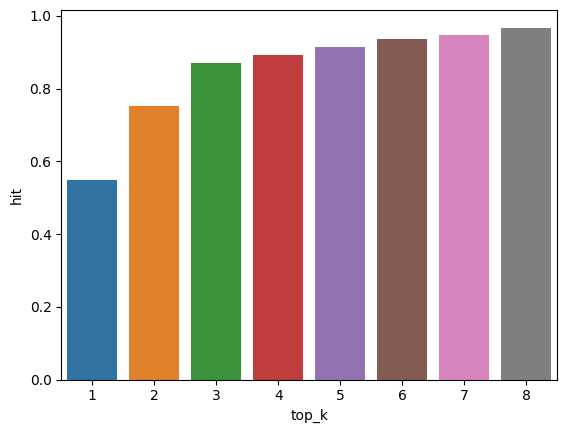

In [15]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', data=retriever_only_hit_stat_df, errorbar=None)

## 加Reranker

In [16]:
from FlagEmbedding import FlagReranker

rerank_model_path = 'stevenluo/bge-reranker-base-ft-v1'

reranker = FlagReranker(rerank_model_path, use_fp16=True)

In [17]:
reranker.device

device(type='cuda')

In [18]:
def rerank(reranker, query, retrieved_docs, top_k=5, debug=False):
    rerank_scores = reranker.compute_score([[query, doc.page_content] for doc in retrieved_docs])
    triads = [(query, doc, score) for doc, score in zip(retrieved_docs, rerank_scores)]
    triads = sorted(triads, key=lambda triad: triad[-1], reverse=True)
    if debug:
        return triads
    return [triad[1] for triad in triads][:top_k]

In [19]:
get_retriever_fn = build_get_ensemble_retriver_fn(weights=[0.5, 0.5])
retirever_multiplier = 3

hit_stat_data = []

top_k_arr = list(range(1, 9))
for k in tqdm(top_k_arr):
    retriever = get_retriever_fn(k * retirever_multiplier)
    for idx, row in test_df.iterrows():
        question = row['question']
        true_uuid = row['uuid']
        chunks = retriever.get_relevant_documents(question)[:k * retirever_multiplier]
        chunks = rerank(reranker, question, chunks, top_k=k)
        retrieved_uuids = [doc.metadata['uuid'] for doc in chunks][:k]

        hit_stat_data.append({
            'question': question,
            'top_k': k,
            'hit': int(true_uuid in retrieved_uuids)
        })
with_reranker_hit_stat_df = pd.DataFrame(hit_stat_data)

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
with_reranker_hit_stat_df.groupby(['top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,top_k,hit_rate
0,1,0.774194
1,2,0.870968
2,3,0.935484
3,4,0.956989
4,5,0.956989
5,6,0.956989
6,7,0.967742
7,8,0.967742


In [21]:
retriever_only_hit_stat_df['reranker'] = 'w/o'
with_reranker_hit_stat_df['reranker'] = 'w/'
hit_stat_df = pd.concat([retriever_only_hit_stat_df, with_reranker_hit_stat_df])

<Axes: xlabel='top_k', ylabel='hit'>

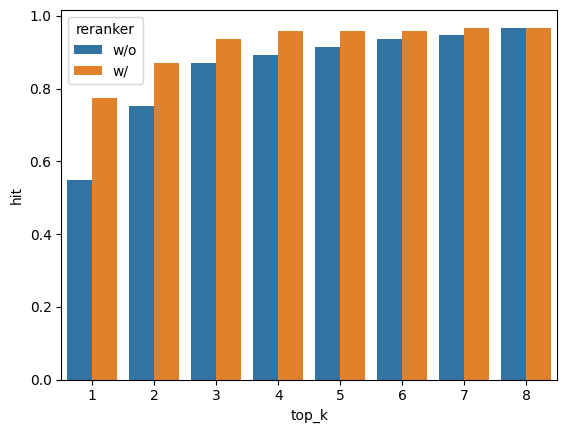

In [22]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', hue='reranker', data=hit_stat_df, errorbar=None)

# 生成答案

In [23]:
from langchain.llms import Ollama

llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434',
    temperature=0
)

In [24]:
def rag(retriever, query, n_chunks=4, retirever_multiplier=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()

    chunks = retriever.get_relevant_documents(query)[:n_chunks * retirever_multiplier]
    chunks = rerank(reranker, query, chunks, top_k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)

    return llm(prompt), chunks

In [25]:
n_chunks = 3

get_retriever_fn = build_get_ensemble_retriver_fn(weights=[0.5, 0.5])
retriever = get_retriever_fn(n_chunks)
print(rag(retriever, '2023年10月美国ISM制造业PMI指数较上月有何变化？')[0])

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


2023年10月美国ISM制造业PMI指数较上个月大幅下降了2.3个百分点。


## 预测

In [26]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(prediction_df, retriever, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(retriever, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [27]:
pred_df = predict(prediction_df, retriever, n_chunks=n_chunks)

  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [28]:
from langchain_openai import ChatOpenAI

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

import time

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        result = judge_llm.invoke(prompt).content
        results.append(result)

        time.sleep(1)
    return results

In [29]:
pred_df['raw_score'] = evaluate(pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
pred_df['raw_score'].unique()

array(['是', '否',
       '否\n\n（注：虽然助手的回答提供了更多的背景信息和解释，但是参考答案只提到了三个国家的名字，而没有提及关于能源进口大国或者俄乌冲突的背景。所以，从字面上看，助手的回答与参考答案并不完全一致。）'],
      dtype=object)

In [31]:
pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
# pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})
# _ = pred_df.pop('raw_score')

In [32]:
pred_df['score'].mean()

0.81